Semana 9 - Reto Calidad del agua

* Lázaro Lara Martínez. Matricula A01793198
* José Mtanous Treviño. Matricula A00169781

Ciencia y Analítica de datos.

Profesor Titular.
Profesor Tutor. Mtro. Mario Alberto Solano Saldaña

14/Noviembre/2022


### Selecciona tus variables independientes X y dependiente Y (semáforo)
Este set de datos en particular no es el mejor para usarse en aprendisaje automático ya que el semáforo es un métrica que depende de las mediciones, es decir el valor del semáforo se establece unicamente con los valores de medición de los contaminantes, en otras palabras, si tenemos las mediciones tenemos el valor del semáforo.  
Por otro lado, suponemos que las mediciones de contaminantes requieren equipo especializado de laboratorio y no es posible hacer estas mediciones insitu, aquí es donde creemos que podemos utilizar un modelo para predecir la calidad del agua con mediciones más simples y que no requieran enviar las muestras al laboratorio, al menos como primer instancia.  
La meta de nuestro modelo es usar datos que sean fáciles de adquirir y de preferencia que se puedan obtener en el mismo lugar de la muestra y con esos datos predecir la calidad del agua. Este modelo tendría utilidad práctica y podría ser una primera herramienta para hacer un catastro más amplio de la calidad de agua en pozos.  
Con nuestro modelo y un kit básico de medición podríamos predecir la calidad del agua de una manera rápida sin necesidad de enviar las muestras al laboratorio, con el riesgo de contaminarlas y el alto costé de usar equipo especializado.
#### Mediciones insitu
Para nuestro modelo solo usaremos mediciones que se puedan hacer directamente en el lugar, así que todas las mediciones que requieren enviarese al laboratorio serán descartadas.  
Las mediciones e instrumentos para realizarlas serían:
* Latitud/Longitud (GPS)
* ORGANISMO_DE_CUENCA (Catálogo)
* ESTADO (Mapa)
* MUNICIPIO (Mapa)
* ACUIFERO (Mapa y Catálog)
* SUBTIPO (Manual)
* CONTAMINANTES (Kit básico de química) 

Varias de estos atributos dependen de la ubicación y son redundantes con las coordenadas, así que esta lista se podría reducir a:
* Latitud/Longitud (GPS)
* SUBTIPO (Manual)
* CONTAMINANTES (Kit básico de química)

Nuestro análisis de basará poder construir un modelo usando estas 3 variables para predecir el semáforo.




In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
import geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import f1_score, precision_score,confusion_matrix, plot_roc_curve,RocCurveDisplay,recall_score, make_scorer,accuracy_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import alpha
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from numpy.lib.shape_base import vsplit
from sklearn import tree
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RepeatedKFold

from sklearn.metrics import average_precision_score, recall_score, precision_score, f1_score, precision_recall_curve
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, plot_confusion_matrix



In [39]:
# cargamos nuestro dataset y creamos uno nuevo con una matriz de contaminantes
path_calidad_subterranea = '../Reto/datos/Escalas_subterranea_clean.csv'
dfCalidadSubterraneaAllColumns = pd.read_csv(path_calidad_subterranea)
dfInSitu = dfCalidadSubterraneaAllColumns[['LATITUD', 'LONGITUD', 'SUBTIPO', 'CONTAMINANTES']]
dfInSitu = dfInSitu.replace(['NINGUNO'],[None])
tmpDf = dfInSitu["CONTAMINANTES"].str.split(pat = ",", expand=True).apply(lambda x : x.value_counts(), axis = 1).fillna(0).astype(int)
dfInSitu = pd.concat([dfInSitu,tmpDf], axis=1)
dfInSitu = dfInSitu.drop(['CONTAMINANTES'],axis=1)
dfInSitu = dfInSitu.drop([''],axis=1)
semaforoDf = pd.DataFrame(dfCalidadSubterraneaAllColumns[['SEMAFORO']], columns=['SEMAFORO'])

In [40]:
dfInSitu.head()

,LATITUD,LONGITUD,SUBTIPO,ALC,AS,CD,CF,CONDUC,CR,DT,FE,FLUO,HG,MN,NI,NO3,PB,SDT_ra,SDT_salin
0,22.20887,-102.02210,POZO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,21.99958,-102.20075,POZO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,22.36685,-102.28801,POZO,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,22.18435,-102.29449,POZO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,23.45138,-110.24480,POZO,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


Cambia a label encoding el semáforo, ej, de ["clase 1", "clase 2", "clase 3"] a [ 1,2,3]

In [8]:
print(semaforoDf.value_counts())
semaforoDf.loc[semaforoDf['SEMAFORO'] == "Verde", "SEMAFORO"] = 1
semaforoDf.loc[semaforoDf['SEMAFORO'] == "Amarillo", "SEMAFORO"] = 2
semaforoDf.loc[semaforoDf['SEMAFORO'] == "Rojo", "SEMAFORO"] = 3
semaforoDf.value_counts()

SEMAFORO
Verde       434
Rojo        387
Amarillo    247
dtype: int64


SEMAFORO
1           434
3           387
2           247
dtype: int64

In [9]:
# También vamos a cambiar el valor de la otra columna categórica que tenemos SUBTIPO
print(dfInSitu['SUBTIPO'].value_counts())
dfInSitu.loc[dfInSitu['SUBTIPO'] == "POZO", "SUBTIPO"] = 1
dfInSitu.loc[dfInSitu['SUBTIPO'] == "MANANTIAL", "SUBTIPO"] = 2
dfInSitu.loc[dfInSitu['SUBTIPO'] == "CENOTE", "SUBTIPO"] = 3
dfInSitu.loc[dfInSitu['SUBTIPO'] == "POZO NORIA", "SUBTIPO"] = 4
dfInSitu.loc[dfInSitu['SUBTIPO'] == "NORIA", "SUBTIPO"] = 5
dfInSitu.loc[dfInSitu['SUBTIPO'] == "DESCARGA", "SUBTIPO"] = 6
dfInSitu.loc[dfInSitu['SUBTIPO'] == "Pozo", "SUBTIPO"] = 1
dfInSitu.loc[dfInSitu['SUBTIPO'] == "BOMBEO CENOTE", "SUBTIPO"] = 7
dfInSitu['SUBTIPO'].value_counts()


POZO             1039
MANANTIAL          12
CENOTE              7
POZO NORIA          4
NORIA               3
DESCARGA            1
Pozo                1
BOMBEO CENOTE       1
Name: SUBTIPO, dtype: int64


1    1040
2      12
3       7
4       4
5       3
6       1
7       1
Name: SUBTIPO, dtype: int64

In [10]:
X = dfInSitu.apply(pd.to_numeric)
Y = semaforoDf.apply(pd.to_numeric)

#Particiòn de datos de entrenamiento y validación. 100 datos de prueba representa el 15%
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.80, random_state=0)

#### Explora que clasificador es el más optimo

#### TreeClassifier

In [11]:
mi_kfoldCV = RepeatedKFold(n_splits=5, n_repeats=3)

modelo = DecisionTreeClassifier()

parameters = {
'criterion' : ['gini', 'entropy'],
'max_depth':range(1,6),
'min_samples_split':range(2,10),
'min_samples_leaf':range(1,10),
}

#Definimos el grid search.
gridFinal=  GridSearchCV (estimator =  modelo,
                        param_grid = parameters,
                        cv = mi_kfoldCV,
                        n_jobs=-1,
                        )

#El fit es como feed, para alimentar con los datos de entrada y de salida

gridFinal.fit(X, Y['SEMAFORO'])
# Enconrramos los mejores parámetros
print(gridFinal.best_params_)

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 7}


#### Random Foresrt Classifier

In [12]:
modelo = RandomForestClassifier()

parameters = {
'criterion' : ['gini', 'entropy'],
'max_depth':range(1,6),
'min_samples_split':range(2,10),
'min_samples_leaf':range(1,10),
}

#Definimos el grid search.
gridFinal=  GridSearchCV (estimator =  modelo,
                        param_grid = parameters,
                        cv = mi_kfoldCV,
                        n_jobs=-1,
                        )

#El fit es como feed, para alimentar con los datos de entrada y de salida

gridFinal.fit(X, Y['SEMAFORO'])
# Enconrramos los mejores parámetros
print(gridFinal.best_params_)

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 7}


In [13]:
# ya que encontramos los mejores parámetros, vamos a ver como se comportan al momento de entrenarlos y probarlos con los sets correndientes
Tree = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=2, min_samples_split=7)
Tree.fit(Xtrain,Ytrain['SEMAFORO'])
YhatTree = Tree.predict(Xtest)
print('---------Recall Tree--------------')
print(recall_score(Ytest,YhatTree, average='weighted'))
print('---------Precision Tree--------------')
print(precision_score(Ytest,YhatTree, average='weighted'))
print('---------F1 Score Tree--------------')
print(f1_score(Ytest,YhatTree, average='weighted'))
print('-------------------------------')
Forest = RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=1, min_samples_split=5)
Forest.fit(Xtrain,Ytrain['SEMAFORO'])
YhatForest = Forest.predict(Xtest)
print('---------Recall Forest--------------')
print(recall_score(Ytest,YhatForest, average='weighted'))
print('---------Precision Forest--------------')
print(precision_score(Ytest,YhatForest, average='weighted'))
print('---------F1 Score Forest--------------')
print(f1_score(Ytest,YhatForest, average='weighted'))


---------Recall Tree--------------
0.8878504672897196
---------Precision Tree--------------
0.902401920509397
---------F1 Score Tree--------------
0.8873307629010939
-------------------------------
---------Recall Forest--------------
0.9626168224299065
---------Precision Forest--------------
0.963797884358632
---------F1 Score Forest--------------
0.9624033193683533


El clasificador Random Forest funciona considerablemente mejor y por lo tanto lo vamos a usar para seguir con nuestro análisis.

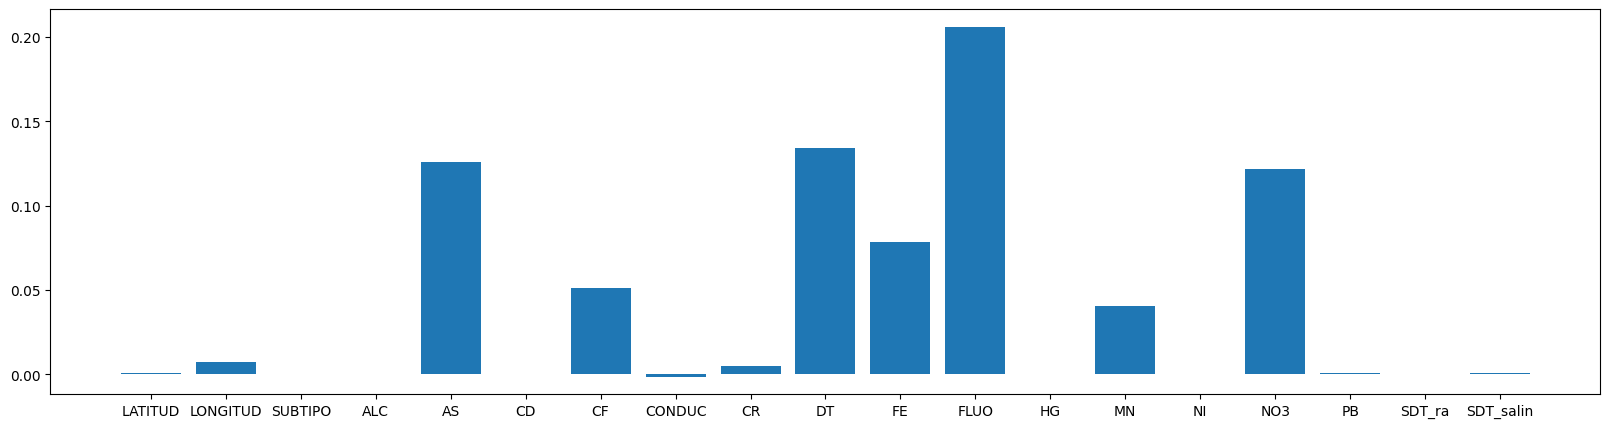

In [34]:
importance = permutation_importance(Forest, Xtest, Ytest['SEMAFORO'], n_repeats=10)

#for feature,v in zip(X.columns,importance['importances_mean']):
#	print('Feature: %s, Score: %.5f' % (feature,v))

#GRAFICAMOS
plt.figure(figsize=(20,5))
plt.bar(X.columns, importance['importances_mean'])
plt.show()


#### Visualiza los resultados del modelo o las predicciones a través de una matriz de confusión

/home/jmtanous/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


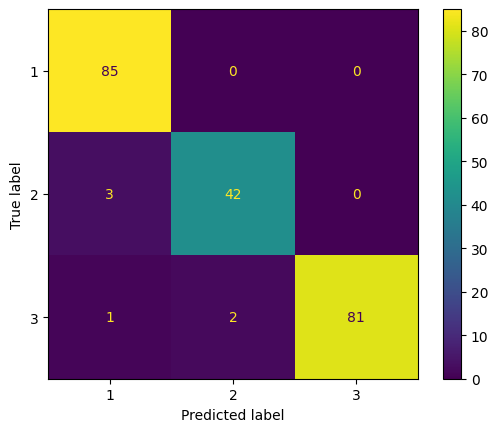

In [38]:
Forest.fit(Xtrain,Ytrain['SEMAFORO'])
plot_confusion_matrix(Forest,Xtest,Ytest['SEMAFORO'])
plt.show()

## Hallazgos y conclusiones
#### La calidad del agua no tiene correlación con su ubicación geográfica
Tanto en la primera parte como en esta, no encontramos correlación evidente entre la calidad del agua subterranea y su ubicación geográfica. Nuestra hipótesis es que como no se registró la profundidad de las muestras la relación entre pozos se pierde. En una misma ubicación en la superficie pueden correr varios rios subterraneas a diferentes profundidades.

#### Fuerte correlación entre contaminantes y calidad del agua
Quizá sea obvio, pero encontramos que la correlación entre la calidad del agua está fuertemente ligada a los contaminantes que se encuentran en esta, tomando principal relavancia el Flour. Si el agua contienen flour, independientemente de la cantidad podemos predecir con bastante confianza que la calidad del agua es mala.

#### Alto desempeño de los clasificadores
Los clasificadores que probamos funcionaron muy bien y diron predicciones de alta calidad. Creemos que esto se debe a la fuerte correlación entre las variables independientes y el semáforo.

#### Reducción de costo de clasificación en campo
Como la calidad del agua está correlacionada con los contaminantes y en menor medida con las cantidades, creemos que se pueden determinar con alta confianza la calidad del agua en el mismo lugar que se toman las muestras, simplemente usando reactivos de baja precisión que detecten las sustancias con más correlación a la calidad del agua. Esto podría ser una alternativa de bajo coste y mucho más rápida que tener que enviar las muestras a laboratorios para determinar con precisión los niveles de contaminantes.